Epoch 10/100, Loss: 0.0514
Epoch 20/100, Loss: 0.0316
Epoch 30/100, Loss: 0.0183
Epoch 40/100, Loss: 0.0193
Epoch 50/100, Loss: 0.0153
Epoch 60/100, Loss: 0.0141
Epoch 70/100, Loss: 0.0121
Epoch 80/100, Loss: 0.0105
Epoch 90/100, Loss: 0.0097
Epoch 100/100, Loss: 0.0094


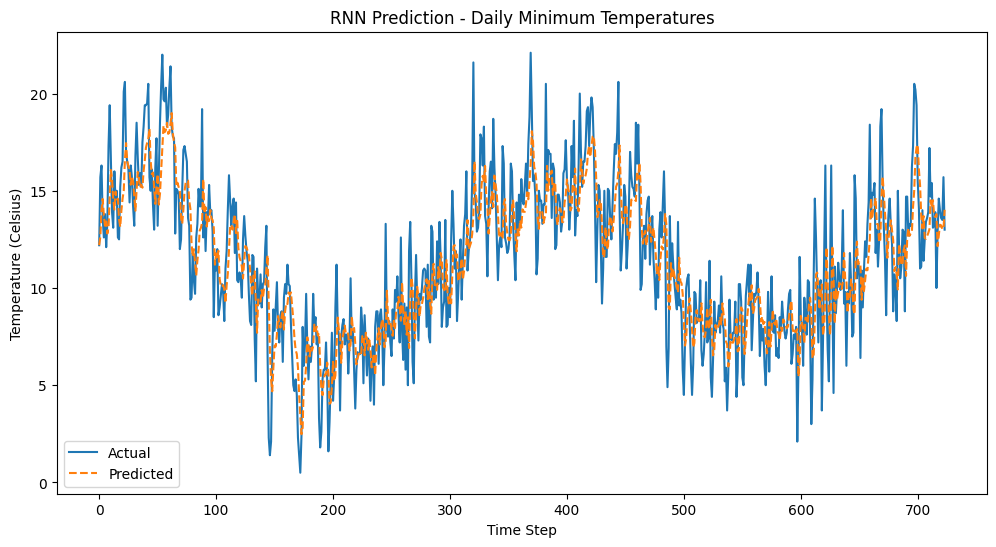

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load and preprocess the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url)
temps = df['Temp'].values.astype('float32').reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
temps_scaled = scaler.fit_transform(temps)

# Step 2: Create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(temps_scaled, seq_length)

X = torch.tensor(X, dtype=torch.float32)  # shape: [samples, seq_len, 1]
y = torch.tensor(y, dtype=torch.float32)

# Step 3: Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # last time step
        return out

model = RNNModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Step 5: Train the model
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Step 6: Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()
    predictions = scaler.inverse_transform(predictions)
    actual = scaler.inverse_transform(y_test.numpy())

# Step 7: Plot results
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual)), actual, label="Actual")
plt.plot(range(len(predictions)), predictions, label="Predicted", linestyle="--")
plt.title("RNN Prediction - Daily Minimum Temperatures")
plt.xlabel("Time Step")
plt.ylabel("Temperature (Celsius)")
plt.legend()
plt.show()